# Neural Network Classification

In [1]:
import sklearn
from sklearn.datasets import make_circles

In [2]:
n_samples=1000
X,y = make_circles(n_samples,noise=0.03,random_state=42) 

In [3]:
import pandas as pd
circles = pd.DataFrame({"X1":X[:, 0],
                        "X2":X[:, 1],
                        "label":y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


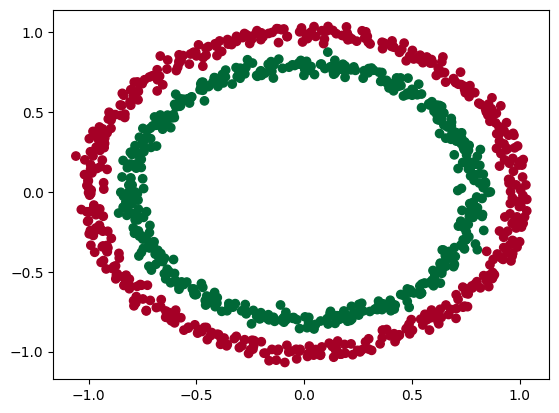

In [4]:
import matplotlib.pyplot as plt
plt.scatter(x=circles['X1'],y=circles['X2'],c=circles['label'],cmap=plt.cm.RdYlGn)

### Turn data into tensors

In [5]:
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
import torch
torch.__version__

'2.2.1+cu121'

In [7]:
type(X)

numpy.ndarray

In [8]:
Xt = torch.from_numpy(X).type(torch.float)
yt=torch.from_numpy(y).type(torch.float)


### Splitting data into training and test test

In [9]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(Xt,yt,train_size = 0.8,random_state=42) 

In [10]:
len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

In [11]:
X_train.shape

torch.Size([800, 2])

### Building a model to classify blue and red dots

In [13]:
import torch
from torch import nn
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [14]:
#Model class which subclasses nn.Module
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        #creating layers for NN
        self.layer_1=nn.Linear(in_features=2,out_features =8) #taking 2 input features and upscaling to 8 features for hidden layer 
        self.layer_2=nn.Linear(in_features=8,out_features=1) #8 hidden layer features become output layer's 1 feature

    def forward(self,x):
            return self.layer_2(self.layer_1(x)) #x->layer1->layer2->output
        

In [15]:
torch.manual_seed(42)
model0 = CircleModel().to(device)
model0

CircleModel(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
)

In [16]:
next(model0.parameters()).device

device(type='cpu')

In [17]:
model0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998]])),
             ('layer_1.bias',
              tensor([ 0.5451,  0.1045, -0.3301,  0.1802, -0.3258, -0.0829, -0.2872,  0.4691])),
             ('layer_2.weight',
              tensor([[-0.2791, -0.1630, -0.0998, -0.2126,  0.0334, -0.3492,  0.3193, -0.3003]])),
             ('layer_2.bias', tensor([0.2730]))])

### Creating model using nn.Sequential
Simpler than class(nn.Module) but less functionality, good for simple NNs

In [18]:
model1 = nn.Sequential (
    nn.Linear(in_features=2,out_features=8),
    nn.Linear(in_features=8,out_features=1)
).to(device)

In [19]:
model1

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=1, bias=True)
)

### Inference

In [20]:
with torch.inference_mode():
    untrained_preds = model0(X_test.to(device))
untrained_preds[:10]

tensor([[-0.3104],
        [-0.4788],
        [ 0.1177],
        [-0.4316],
        [ 0.0967],
        [-0.0059],
        [-0.4633],
        [-0.3526],
        [ 0.1180],
        [-0.4903]])

### Loss function and optimizer

In [21]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model0.parameters(),lr=0.1)

### Accuracy Function 

In [22]:
def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    return (correct/len(y_pred)) * 100


## Training loop 

#### Raw logits-> prediction probabiliies -> prediction labels

In [23]:
#model outputs are raw logits
model0.eval()
with torch.inference_mode():
    y_logits = model0(X_test.to(device))
y_logits[:5]

tensor([[-0.3104],
        [-0.4788],
        [ 0.1177],
        [-0.4316],
        [ 0.0967]])

In [24]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

#### Need to make y_logits into same format as y_test as y_logit is model0's y output when we feed it x_test
We do this by passing it through an activation function, like sigmoid

In [25]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs[:5]

tensor([[0.4230],
        [0.3825],
        [0.5294],
        [0.3937],
        [0.5242]])

In [26]:
#rounding off prediction probability to get labels
torch.round(y_pred_probs)[:5]

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]])

### Putting it all together:

In [27]:
y_pred_labels = torch.round(torch.sigmoid(model0(X_test.to(device))))
y_pred_labels[:5]

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]], grad_fn=<SliceBackward0>)

### Testing and training loop

In [28]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100
X_train, y_train =X_train.to(device), y_train.to(device)
X_test, y_test =X_test.to(device), y_test.to(device) 

for epoch in range(epochs):
    model0.train()
    #1. Forward pass
    y_logits = model0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) #turn logits-> pred probs

    #2.Loss/Accuracy calculation
    loss = loss_fn(y_logits,y_train) #BCEwithLogits expects logits 
    acc = accuracy_fn(y_train,y_pred)

    #3. Optimizer zero grad
    optimizer.zero_grad()
    #4. Loss backwards(Backpropagation)
    loss.backward()
    #5. Optimizer step
    optimizer.step()

    model0.eval()
    with torch.inference_mode():
         #1. Forward pass
        test_logits = model0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        #2.Loss/Accuracy calculation
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_test,test_pred)

    #Print out whats happening
    if epoch%10==0:
        print(f"Epoch: {epoch}| Loss:{loss:.3f}| Acc:{acc:.2f}%| Test Loss:{test_loss:.3f}| Test Acc:{test_acc:.2f}%")
    
        

Epoch: 0| Loss:0.705| Acc:48.25%| Test Loss:0.694| Test Acc:53.00%
Epoch: 10| Loss:0.701| Acc:48.62%| Test Loss:0.692| Test Acc:53.00%
Epoch: 20| Loss:0.698| Acc:48.38%| Test Loss:0.691| Test Acc:54.50%
Epoch: 30| Loss:0.697| Acc:48.75%| Test Loss:0.691| Test Acc:54.00%
Epoch: 40| Loss:0.696| Acc:49.00%| Test Loss:0.691| Test Acc:54.00%
Epoch: 50| Loss:0.695| Acc:49.00%| Test Loss:0.691| Test Acc:54.50%
Epoch: 60| Loss:0.695| Acc:49.00%| Test Loss:0.691| Test Acc:53.00%
Epoch: 70| Loss:0.694| Acc:49.25%| Test Loss:0.691| Test Acc:53.50%
Epoch: 80| Loss:0.694| Acc:49.25%| Test Loss:0.692| Test Acc:54.00%
Epoch: 90| Loss:0.694| Acc:49.62%| Test Loss:0.692| Test Acc:54.50%


## Why isn't our model learning?

In [29]:
import requests
from pathlib import Path

#Downloading helper functions from learnpytorch repo

if Path("helper_functions.py").is_file():
    print("Already downloaded.")
else:
    print("Downloading...")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py","wb") as f:
        f.write(request.content)

Already downloaded.


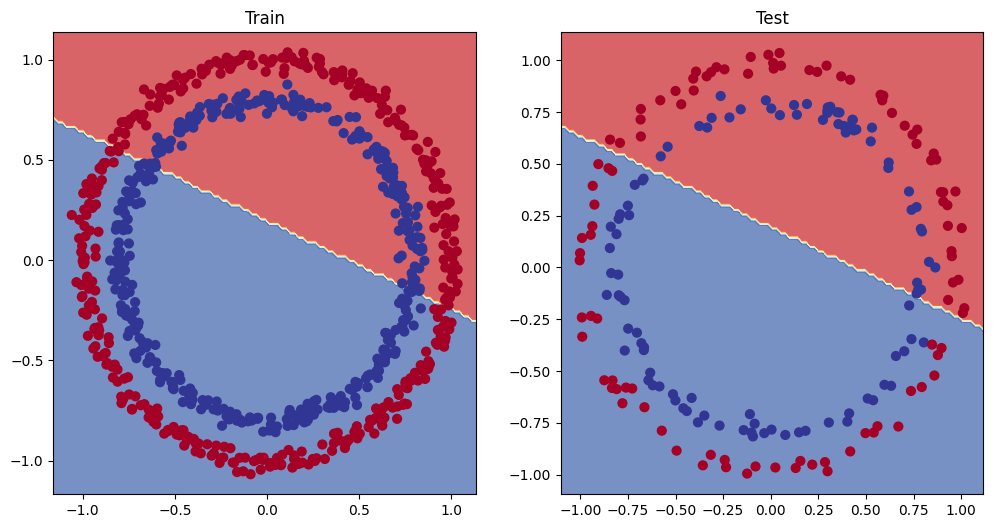

In [30]:
from helper_functions import plot_predictions,plot_decision_boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model0,X_test,y_test)

#### As out data plot is circular, we need to use non linear activation parameters. We're using linear activations here so it cannot fit our data properly

### Non Linear Model

In [31]:
import torch 
from torch import nn

class CircleModelv2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2,out_features=16)
        self.layer2 = nn.Linear(in_features=16,out_features=16)
        self.layer3=  nn.Linear(in_features=16,out_features=1)
        self.relu = nn.ReLU() #non - linear activations functions

    def forward(self,x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))      



In [32]:
model2 = CircleModelv2().to(device)
model2

CircleModelv2(
  (layer1): Linear(in_features=2, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

In [33]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model2.parameters(),lr=0.1)

In [34]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000
X_train, y_train =X_train.to(device), y_train.to(device)
X_test, y_test =X_test.to(device), y_test.to(device) 

for epoch in range(epochs):
    model2.train()
    #1. Forward pass
    y_logits = model2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) #turn logits-> pred probs

    #2.Loss/Accuracy calculation
    loss = loss_fn(y_logits,y_train) #BCEwithLogits expects logits 
    acc = accuracy_fn(y_train,y_pred)

    #3. Optimizer zero grad
    optimizer.zero_grad()
    #4. Loss backwards(Backpropagation)
    loss.backward()
    #5. Optimizer step
    optimizer.step()

    model2.eval()
    with torch.inference_mode():
         #1. Forward pass
        test_logits = model2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        #2.Loss/Accuracy calculation
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_test,test_pred)

    #Print out whats happening
    if epoch%100==0:
        print(f"Epoch: {epoch}| Loss:{loss:.3f}| Acc:{acc:.3f}%| Test Loss:{test_loss:.3f}| Test Acc:{test_acc:.3f}%")
    
        

Epoch: 0| Loss:0.698| Acc:50.000%| Test Loss:0.698| Test Acc:50.000%
Epoch: 100| Loss:0.690| Acc:56.250%| Test Loss:0.691| Test Acc:51.500%
Epoch: 200| Loss:0.687| Acc:52.875%| Test Loss:0.689| Test Acc:52.000%
Epoch: 300| Loss:0.683| Acc:53.625%| Test Loss:0.686| Test Acc:52.500%
Epoch: 400| Loss:0.677| Acc:54.000%| Test Loss:0.682| Test Acc:53.500%
Epoch: 500| Loss:0.670| Acc:56.000%| Test Loss:0.676| Test Acc:55.500%
Epoch: 600| Loss:0.659| Acc:62.375%| Test Loss:0.668| Test Acc:58.000%
Epoch: 700| Loss:0.642| Acc:75.500%| Test Loss:0.653| Test Acc:68.500%
Epoch: 800| Loss:0.613| Acc:87.375%| Test Loss:0.629| Test Acc:85.000%
Epoch: 900| Loss:0.564| Acc:97.250%| Test Loss:0.587| Test Acc:93.000%


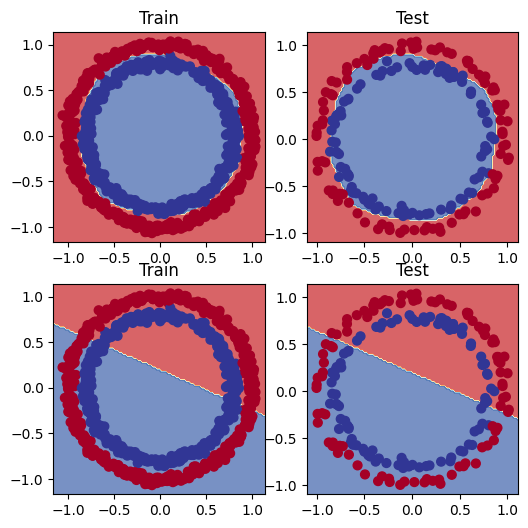

In [36]:
plt.figure(figsize=(6,6))
plt.subplot(2,2,1)
plt.title("Train")
plot_decision_boundary(model2,X_train,y_train)
plt.subplot(2,2,2)
plt.title("Test")
plot_decision_boundary(model2,X_test,y_test)
plt.subplot(2,2,3)
plt.title("Train")
plot_decision_boundary(model0,X_train,y_train)
plt.subplot(2,2,4)
plt.title("Test")
plot_decision_boundary(model0,X_test,y_test)

## Multiclass classification

In [37]:
import torch
from torch import nn 
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

classes=4
features=2
seed=42

In [38]:
#Creating dataset
X_blob, y_blob  = make_blobs(n_samples=1000,
                             n_features=features,
                             centers=classes,
                             cluster_std=1.5,
                             random_state=seed)
#Turning data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)

#Test/Train split
X_train,X_test,y_train,y_test = train_test_split(X_blob,
                                                 y_blob,
                                                train_size=0.8,
                                                random_state=seed)


In [39]:
len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

In [40]:
y_blob.shape

torch.Size([1000])

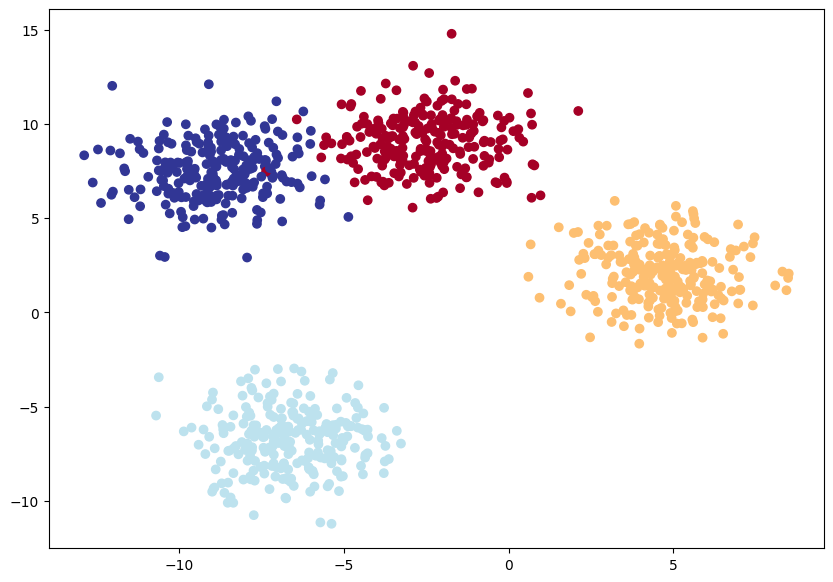

In [41]:
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu)

### Building the model 

In [42]:
class BlobModel(nn.Module):
    def __init__(self,in_features,out_features,hidden=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=in_features,out_features=hidden),
            nn.ReLU(),
            nn.Linear(in_features=hidden,out_features=hidden),
            nn.ReLU(),
            nn.Linear(in_features=hidden,out_features=out_features)
        )
    def forward(self,x):
        return self.linear_layer_stack(x)

model3 = BlobModel(in_features=2,out_features=4,hidden=8)

### Loss func and Optimizer

In [43]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model3.parameters(),lr=0.1)

### Making Predictions
*  Model predictions ->logits,
* Convert logits -> prediction % ->  labels
* Select most label of highest % from output features 

In [48]:
model3.eval()
with torch.inference_mode():
    logits = model3(X_test)
    pred_probs = torch.softmax(logits,dim=1)
    pred_label = torch.argmax(pred_probs,dim=1)
print(f"{logit[:5]},Min:{logit.min():.2f},Max:{logit.max():.2f}")
print(f"{pred_probs[:5]},Min:{pred_probs.min():.2f},Max:{pred_probs.max():.2f}")
print(pred_label[:10])
print(y_blob[:10])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]]),Min:-2.15,Max:0.25
tensor([[1.6515e-06, 1.0000e+00, 6.5754e-10, 2.1385e-10],
        [5.9741e-04, 4.0740e-07, 9.7746e-06, 9.9939e-01],
        [3.1371e-05, 2.1165e-05, 9.9989e-01, 6.1552e-05],
        [1.3729e-05, 9.9998e-01, 1.1796e-06, 3.5901e-07],
        [9.9992e-01, 8.3726e-05, 6.6887e-09, 3.1906e-07]]),Min:0.00,Max:1.00
tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
tensor([3, 2, 2, 1, 1, 2, 1, 2, 2, 1])


### Training and testing loop

In [49]:
torch.manual_seed = seed
torch.cuda.manual_seed = seed
epochs =1000

for epoch in range(epochs):
    ###Training
    model3.train()
    #1.forward pass
    logits = model3(X_train)
    y_preds =torch.softmax(logits,dim=1).argmax(dim=1)
    #2.calculate loss 
    loss = loss_fn(logits,y_train)
    acc = accuracy_fn(y_true=y_train,
                     y_pred=y_preds)
    #3.back propagation
    optimizer.zero_grad()
    loss.backward()
    #4.gradient descent 
    optimizer.step()

    ###Testing
    model3.eval()
    test_logits = model3(X_test)
    test_preds = torch.softmax(test_logits,dim=1).argmax(dim=1)
    test_loss =loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,
                          y_pred=test_preds)
    #Print
    if epoch%10==0:
        print(f"Epoch:{epoch}| Loss:{loss:.3f}| Acc:{acc:.3f}| Test Loss:{test_loss:.3f}| Test Acc:{test_acc:.3f}")

    

Epoch:0| Loss:0.022| Acc:99.250| Test Loss:0.011| Test Acc:99.500
Epoch:10| Loss:0.022| Acc:99.250| Test Loss:0.011| Test Acc:99.500
Epoch:20| Loss:0.022| Acc:99.250| Test Loss:0.011| Test Acc:99.500
Epoch:30| Loss:0.022| Acc:99.250| Test Loss:0.011| Test Acc:99.500
Epoch:40| Loss:0.022| Acc:99.250| Test Loss:0.011| Test Acc:99.500
Epoch:50| Loss:0.022| Acc:99.250| Test Loss:0.011| Test Acc:99.500
Epoch:60| Loss:0.022| Acc:99.250| Test Loss:0.011| Test Acc:99.500
Epoch:70| Loss:0.022| Acc:99.250| Test Loss:0.011| Test Acc:99.500
Epoch:80| Loss:0.022| Acc:99.250| Test Loss:0.011| Test Acc:99.500
Epoch:90| Loss:0.022| Acc:99.250| Test Loss:0.011| Test Acc:99.500
Epoch:100| Loss:0.022| Acc:99.250| Test Loss:0.011| Test Acc:99.500
Epoch:110| Loss:0.022| Acc:99.250| Test Loss:0.011| Test Acc:99.500
Epoch:120| Loss:0.022| Acc:99.250| Test Loss:0.011| Test Acc:99.500
Epoch:130| Loss:0.022| Acc:99.250| Test Loss:0.011| Test Acc:99.500
Epoch:140| Loss:0.022| Acc:99.250| Test Loss:0.011| Test Ac

### Visualize, Visualize, Visualize

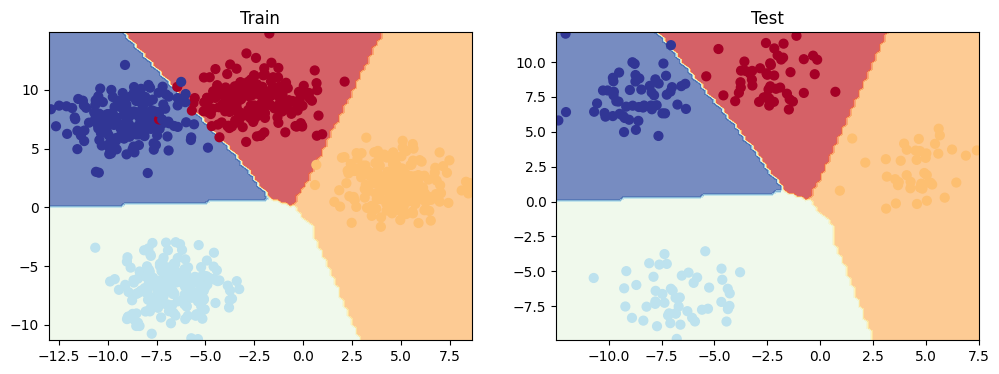

In [50]:
from helper_functions import plot_predictions,plot_decision_boundary
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model3,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model3,X_test,y_test)


### Classification Metrics
* Accuracy - good for balanced classification data
* Precision - good for unbalanced, anti false positives 
* Recall - good for unbalanced, anti false negatives
  ##### (Precision and Recall are inversely proportional to each other)
* F1-score - (combo of precision and recall)
* Confusion Matrix - tabular comparison of preds and true values
* Classification report - report of all main metrics


### Torchmetrics

In [47]:
from torchmetrics import Accuracy
torchmetric_acc = Accuracy(task = 'multiclass',num_classes=4)
torchmetric_acc(y_preds,y_train)

tensor(0.9925)